In [2]:
!pip install pandas numpy scikit-learn deap matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random

In [4]:
df = pd.read_csv("data_lab2.csv")

In [5]:
def create_lag_features(df, lags):
    df_lagged = pd.DataFrame()
    for col, lag in lags.items():
        df_lagged[f"{col}(lag)"] = df[col].shift(lag)
    df_lagged["IPC(+1)"] = df["IPC"].shift(-1)
    df_lagged.dropna(inplace=True)
    return df_lagged.reset_index(drop=True)

In [6]:
lags = {"IOC": 0, "IPC": 0, "KVVE": 7, "M0": 7, "M2": 7}
data = create_lag_features(df, lags)

In [7]:
results = []
true_vals = []
pred_vals = []

In [8]:
if "FitnessMin" not in creator.__dict__:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMin)

In [9]:
for i in range(10):
    window = data.iloc[i:i+12]
    X = window.drop("IPC(+1)", axis=1).values
    y = window["IPC(+1)"].values

In [10]:
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [11]:
    mlp = MLPRegressor(hidden_layer_sizes=(5,), activation='relu', max_iter=1, warm_start=True)
    mlp.fit(X_scaled, y_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(5,), max_iter=1, warm_start=True)

In [12]:
    n_weights = sum(w.size for w in mlp.coefs_ + mlp.intercepts_)
    toolbox = base.Toolbox()
    toolbox.register("attr_float", lambda: random.uniform(-1.0, 1.0))
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_weights)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [13]:
    def eval_nn(individual):
        start = 0
        i_weights = []
        for coef in mlp.coefs_ + mlp.intercepts_:
            shape = coef.shape
            size = np.prod(shape)
            new_weights = np.array(individual[start:start + size]).reshape(shape)
            i_weights.append(new_weights)
            start += size
        mlp.coefs_ = i_weights[:len(mlp.coefs_)]
        mlp.intercepts_ = i_weights[len(mlp.coefs_):]
        y_pred = mlp.predict(X_scaled)
        return (mean_squared_error(y_scaled, y_pred),)

In [14]:
    toolbox.register("evaluate", eval_nn)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

In [15]:
    pop = toolbox.population(n=20)
    hof = tools.HallOfFame(1)
    algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=20, halloffame=hof, verbose=False)

([[0.40566923940000454,
   -0.8666727556425371,
   -0.6983189053451428,
   -0.14320064080134975,
   0.4696671482119803,
   0.8692470520347668,
   0.004300688823145604,
   -0.8885967727550177,
   -0.42964027059705134,
   0.38698477308989543,
   1.2222946077214065,
   0.25158830441677327,
   -0.9768558665811764,
   0.21977477485282204,
   -0.9789669337493416,
   -0.6891076255001086,
   0.3786070439096476,
   0.49075437642837993,
   -0.9405104495722141,
   -1.0076999157961295,
   -1.5555326904960656,
   0.7951635338447514,
   -1.2070164947625646,
   0.734115022439181,
   0.9904837904830166,
   -0.008111368817292242,
   -0.4579814929463854,
   0.38630666800421776,
   0.9844708452154969,
   -0.17360842082513295,
   -0.16884143773610805,
   -0.222581628353953,
   -0.616643726081758,
   -0.4127712540945825,
   0.19722843546780533,
   0.6906045054276164],
  [0.40566923940000454,
   -1.3340499295614294,
   -0.6983189053451428,
   -0.14320064080134975,
   0.4696671482119803,
   0.253121623348367

In [16]:

    start = 0
    i_weights = []
    for coef in mlp.coefs_ + mlp.intercepts_:
        shape = coef.shape
        size = np.prod(shape)
        new_weights = np.array(hof[0][start:start + size]).reshape(shape)
        i_weights.append(new_weights)
        start += size

In [17]:
    mlp.coefs_ = i_weights[:len(mlp.coefs_)]
    mlp.intercepts_ = i_weights[len(mlp.coefs_):]

In [18]:

    mlp.max_iter = 300
    mlp.fit(X_scaled, y_scaled)

MLPRegressor(hidden_layer_sizes=(5,), max_iter=300, warm_start=True)

In [19]:

    y_pred_scaled = mlp.predict(X_scaled)
    y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    mse_real = mean_squared_error(y, y_pred_real)

In [20]:
    results.append({
        "Window": f"{i+1}-{i+12}",
        "Real IPC(+1)": y[-1],
        "Predicted IPC(+1)": y_pred_real[-1],
        "MSE": mse_real
    })
    true_vals.append(y[-1])
    pred_vals.append(y_pred_real[-1])

In [21]:

df_results = pd.DataFrame(results)
display(df_results)

,Window,Real IPC(+1),Predicted IPC(+1),MSE
0,10-21,107.169315,110.514227,32.532465


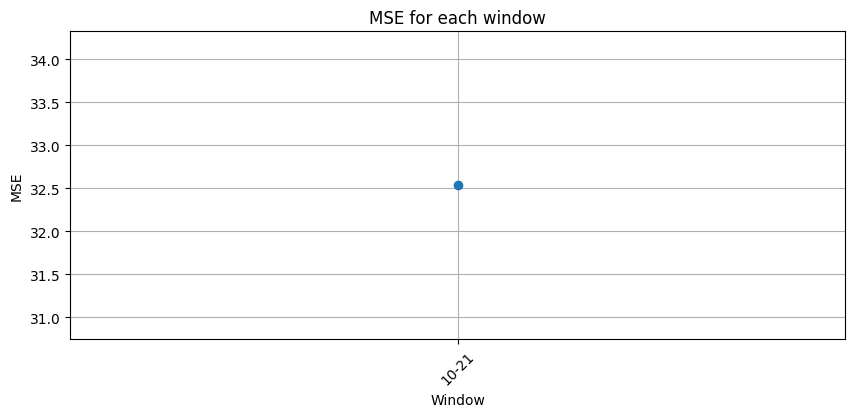

In [23]:

plt.figure(figsize=(10, 4))
plt.plot(df_results["Window"], df_results["MSE"], marker='o')
plt.title("MSE for each window")
plt.xlabel("Window")
plt.ylabel("MSE")
plt.grid()
plt.xticks(rotation=45)
plt.show()


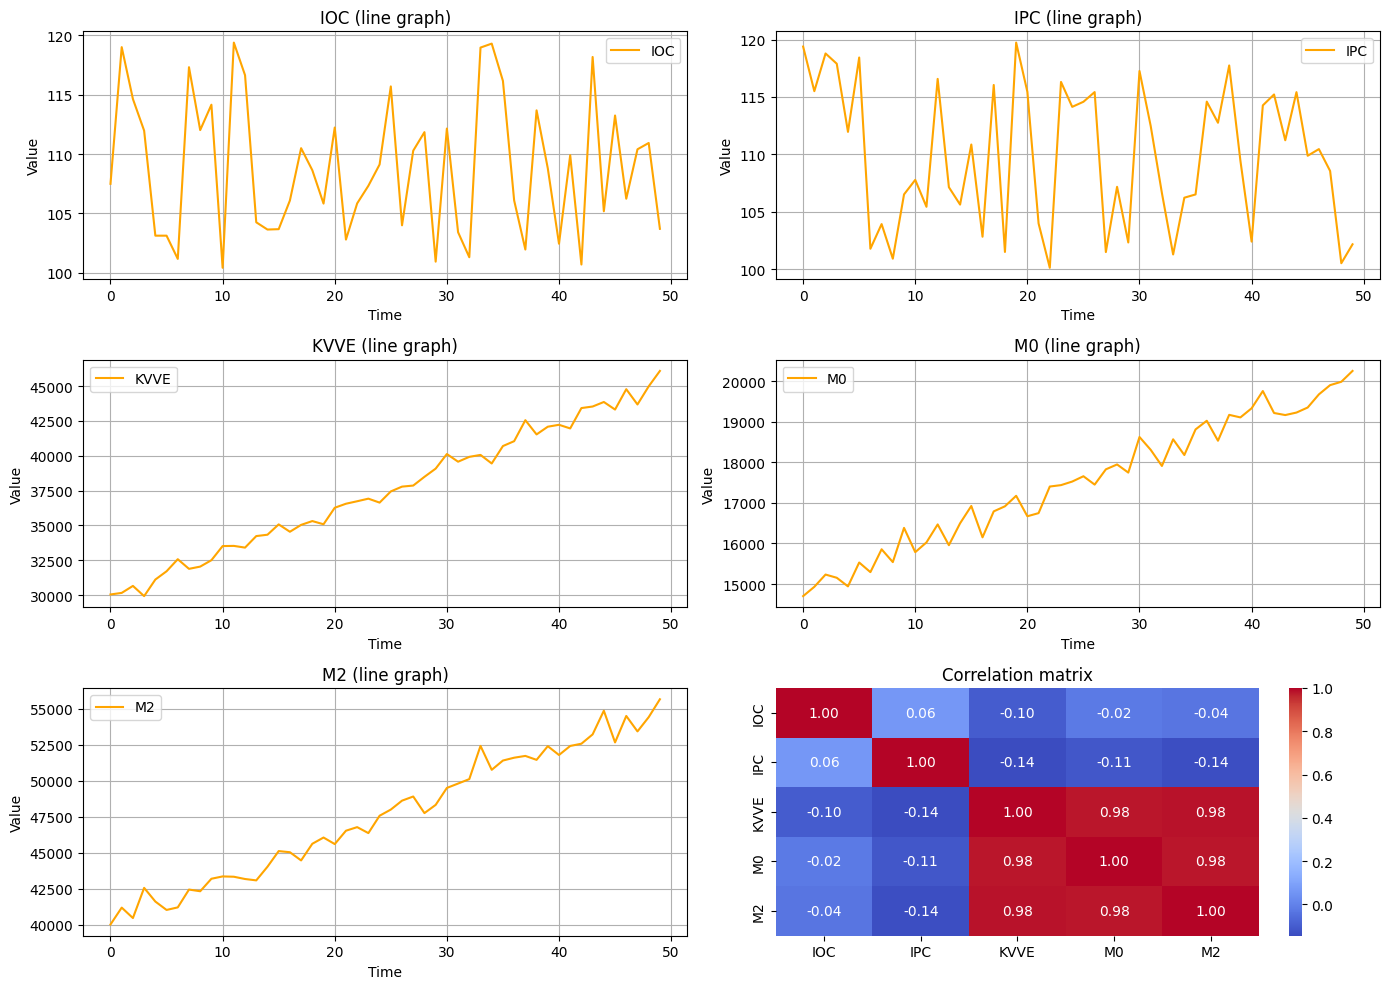

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()
columns = ["IOC", "IPC", "KVVE", "M0", "M2"]
for i, col in enumerate(columns):
    axs[i].plot(df[col], color='orange', label=col)
    axs[i].set_title(f"{col} (line graph)")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
corr = df[columns].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", ax=axs[5])
axs[5].set_title("Correlation matrix")

plt.tight_layout()
plt.show()